Dataset head:
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


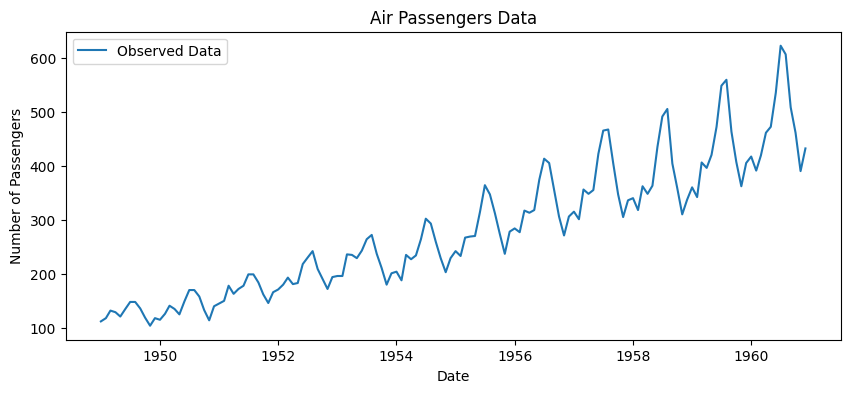

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For neural networks using TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the Air Passengers dataset from GitHub
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(data_url)

# Convert the 'Month' column to datetime and set it as the index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.columns = ['Passengers']  # Rename for clarity

# Display the first few rows
print("Dataset head:")
print(df.head())

# Plot the raw time series
plt.figure(figsize=(10, 4))
plt.plot(df['Passengers'], label='Observed Data')
plt.title('Air Passengers Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [2]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

# Function to create a supervised learning dataset from time series
def create_dataset(dataset, look_back=1):
    """
    This function transforms a time series into a supervised learning format.
    Each X sample contains `look_back` consecutive time steps and the y is the next time step.
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Set look_back period (number of past observations to use for predicting the next value)
look_back = 12  # using the previous 12 months to predict the next month
X, y = create_dataset(data_scaled, look_back)

# Reshape input to [samples, time_steps, features] for LSTM (features=1)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 105
Testing samples: 27


In [3]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0551 - val_loss: 0.3649
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0406 - val_loss: 0.2944
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0281 - val_loss: 0.2237
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0177 - val_loss: 0.1537
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0107 - val_loss: 0.0891
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0097 - val_loss: 0.0427
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0147 - val_loss: 0.0261
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0168 - val_loss: 0.0265
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0126 - val_loss: 0.0302
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - val_loss: 0.0284
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075 - val_loss: 0.0238
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_l

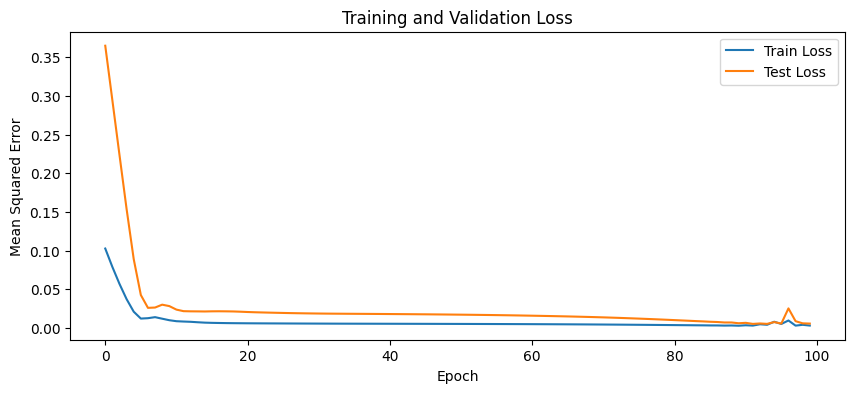

In [4]:
# Train the model
epochs = 100
batch_size = 16

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), verbose=1, shuffle=False)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


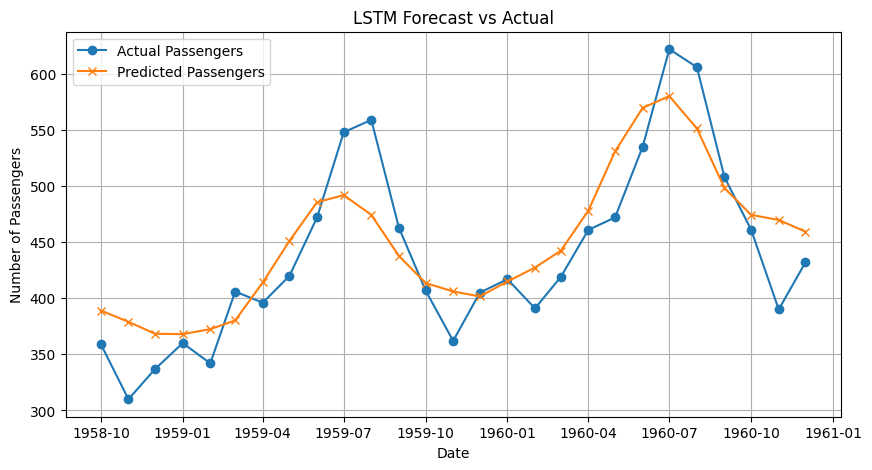

In [5]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse-transform predictions and true values to original scale
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a time index for test set plotting (starting after training period)
test_index = df.index[look_back + train_size: len(df)]

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_index, y_test_inv, label='Actual Passengers', marker='o')
plt.plot(test_index, y_pred_inv, label='Predicted Passengers', marker='x')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()